# **Preprocessing**

In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.tree import DecisionTreeClassifier
from scipy import stats

In [44]:
from google.colab import files
import io
import pandas as pd


uploaded = files.upload()
for file_name in uploaded.keys():
    data = pd.read_csv(io.BytesIO(uploaded[file_name]), delimiter=',')

Saving Raw Data.csv to Raw Data (3).csv


In [112]:
raw_data = pd.read_csv('/content/Raw Data (3).csv', delimiter=',')

In [113]:
raw_data.head()

,Nitrogen,Phosphorus,Potassium,Temperature,Humidity,pH,Rainfall,Crop
0,90,42,43,20.879744,82.002744,6.502985,202.935536,rice
1,85,58,41,21.770462,80.319644,7.038096,226.655537,rice
2,60,55,44,23.004459,82.320763,7.840207,263.964248,rice
3,74,35,40,26.491096,80.158363,6.980401,242.864034,rice
4,78,42,42,20.130175,81.604873,7.628473,262.717340,rice


In [47]:
print(raw_data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2200 entries, 0 to 2199
Data columns (total 8 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Nitrogen     2200 non-null   int64  
 1   Phosphorus   2200 non-null   int64  
 2   Potassium    2200 non-null   int64  
 3   Temperature  2200 non-null   float64
 4   Humidity     2200 non-null   float64
 5   pH           2200 non-null   float64
 6   Rainfall     2200 non-null   float64
 7   Crop         2200 non-null   object 
dtypes: float64(4), int64(3), object(1)
memory usage: 137.6+ KB
None


Scaling

In [114]:
# List of columns to standardize (all columns except 'Crop')
numerical_columns = ['Nitrogen', 'Phosphorus', 'Potassium', 'Temperature', 'Humidity', 'pH', 'Rainfall']

# Initialize the StandardScaler
scaler = StandardScaler()

# Standardize the numerical columns and keep the 'Crop' column intact
raw_data[numerical_columns] = scaler.fit_transform(raw_data[numerical_columns])

# The 'Crop' column remains unchanged
print(raw_data.head())

   Nitrogen  Phosphorus  Potassium  Temperature  Humidity        pH  Rainfall  \
0  1.068797   -0.344551  -0.101688    -0.935587  0.472666  0.043302  1.810361   
1  0.933329    0.140616  -0.141185    -0.759646  0.397051  0.734873  2.242058   
2  0.255986    0.049647  -0.081939    -0.515898  0.486954  1.771510  2.921066   
3  0.635298   -0.556811  -0.160933     0.172807  0.389805  0.660308  2.537048   
4  0.743673   -0.344551  -0.121436    -1.083647  0.454792  1.497868  2.898373   

   Crop  
0  rice  
1  rice  
2  rice  
3  rice  
4  rice  


In [115]:
cleaned_data = raw_data.copy()

In [50]:
from google.colab import files

cleaned_data.to_csv('data.csv', index=False)
files.download('data.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# **EDA**

In [116]:
data = cleaned_data.drop(columns=['Crop'])

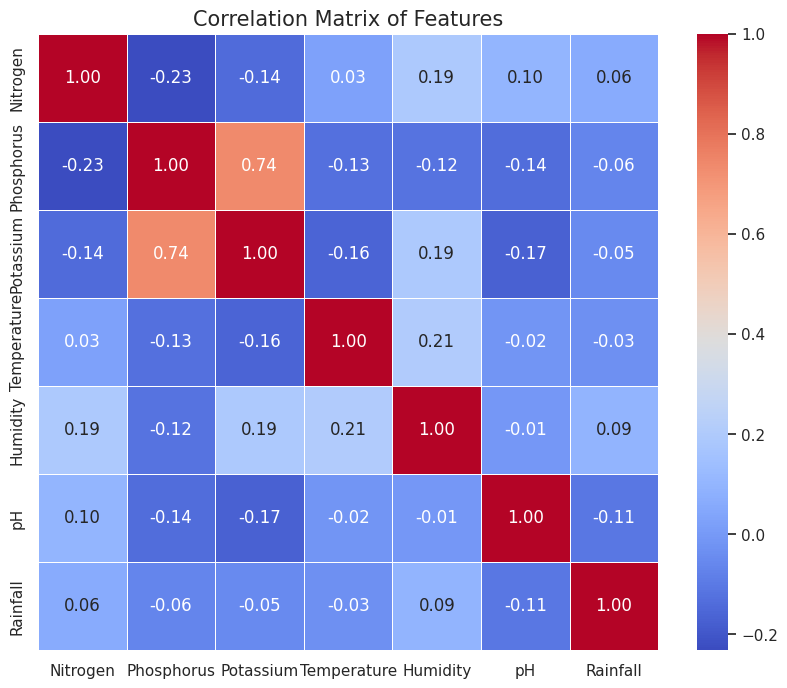

In [117]:
# Compute the correlation matrix
correlation_matrix = data.corr()

# Plot the heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)

# Add title
plt.title('Correlation Matrix of Features', size=15)

# Show the plot
plt.show()


# **Clustering**

In [40]:
!pip install kneed

In [41]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from scipy import stats
import numpy as np
from kneed import KneeLocator

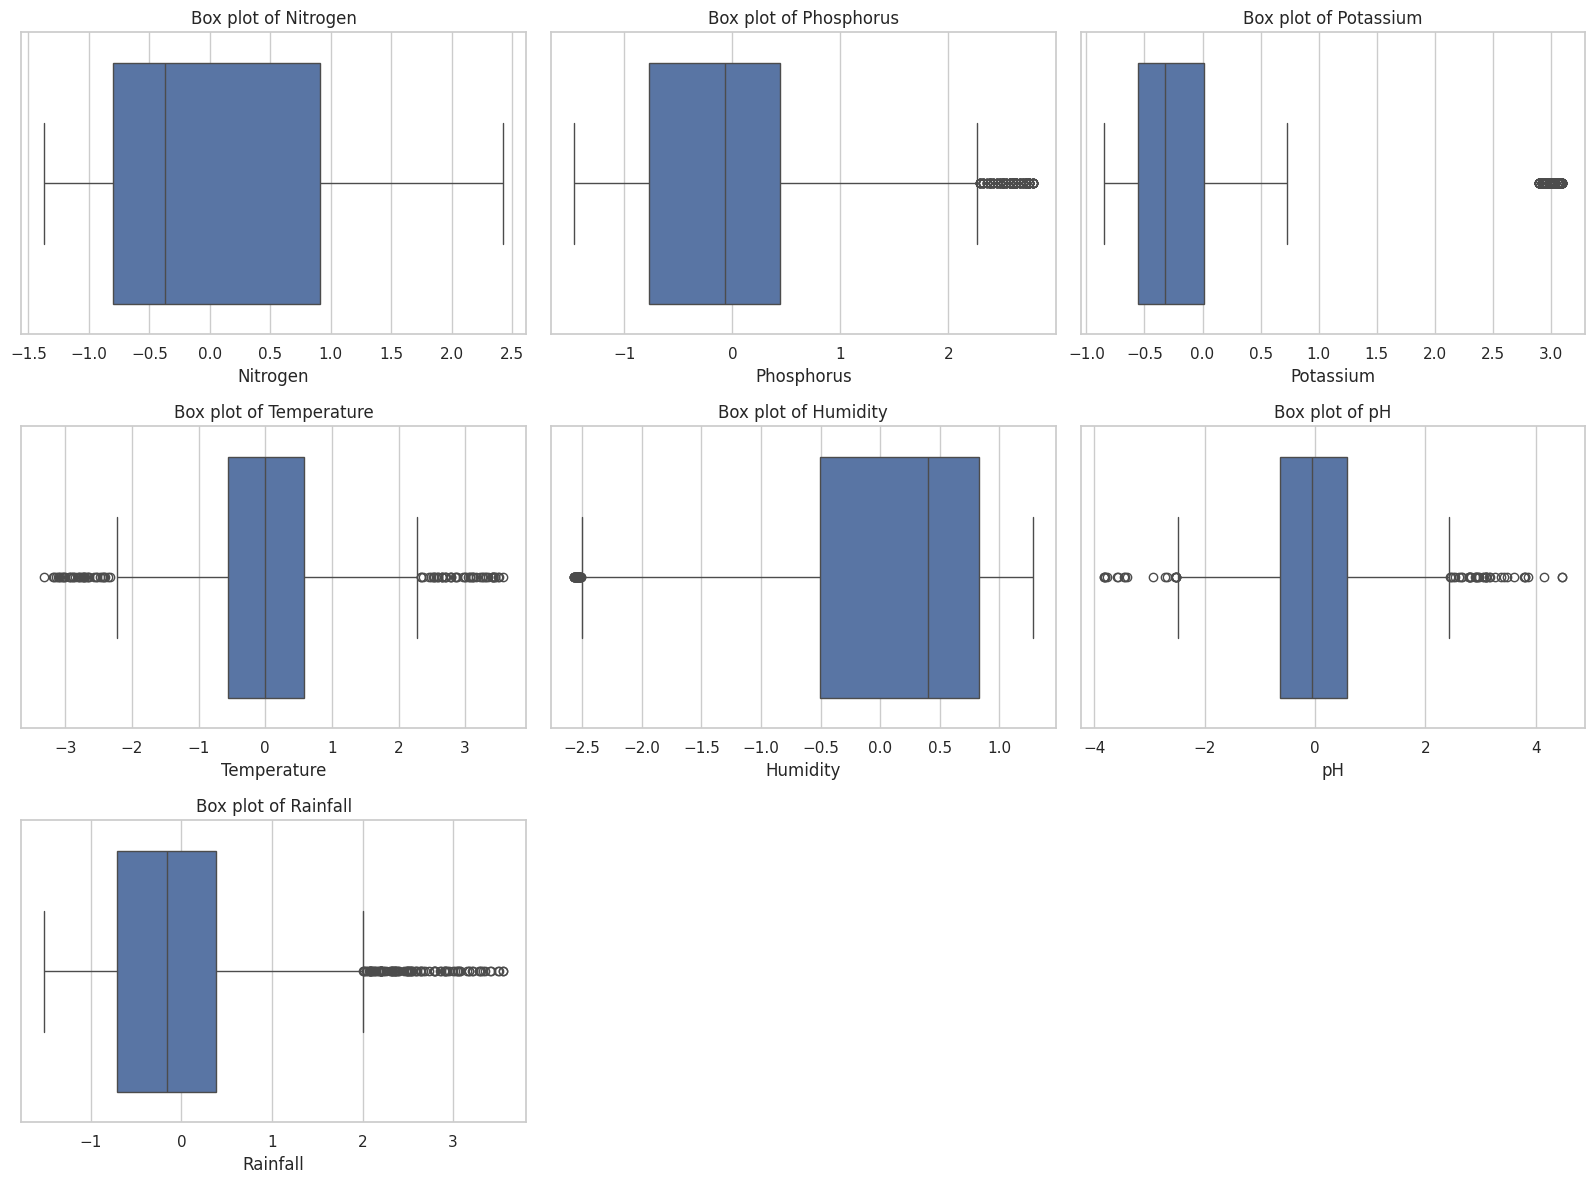

In [118]:
# Set the style of seaborn plots
sns.set(style="whitegrid")

# Plot box plots for each feature in the dataset
# We will exclude the 'Cluster' column if already added, and any non-numeric columns
features = data.select_dtypes(include=[np.number]).columns.tolist()  # Select numeric columns

plt.figure(figsize=(16, 12))  # Adjust size for better readability
for i, feature in enumerate(features, 1):
    plt.subplot(3, 3, i)  # Adjust subplot grid as per the number of features
    sns.boxplot(data=cleaned_data, x=feature)
    plt.title(f'Box plot of {feature}')

plt.tight_layout()
plt.show()


Evaluate the clusters using elbow method

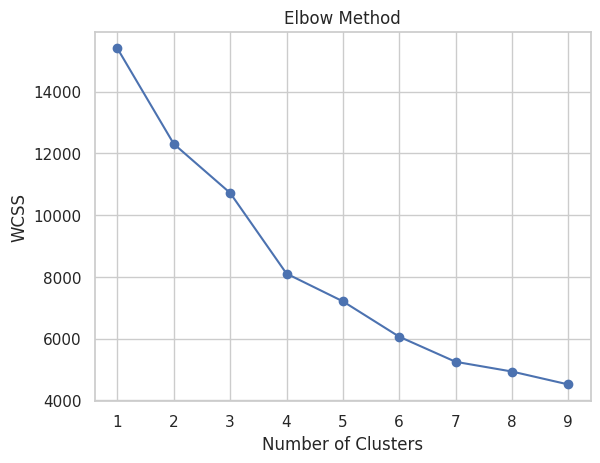

Optimal number of clusters: 4


In [119]:
# Calculate WCSS for a range of cluster numbers
wcss = []
for i in range(1, 10):
    kmeans = KMeans(n_clusters=i, random_state=42)
    kmeans.fit(data)
    wcss.append(kmeans.inertia_)

# Plot the WCSS values
plt.plot(range(1, 10), wcss, marker='o')
plt.title('Elbow Method')
plt.xlabel('Number of Clusters')
plt.ylabel('WCSS')
plt.show()

# Determine the optimal number of clusters using the KneeLocator
knee = KneeLocator(range(1, 10), wcss, curve='convex', direction='decreasing')
optimal_clusters = knee.elbow

print(f"Optimal number of clusters: {optimal_clusters}")


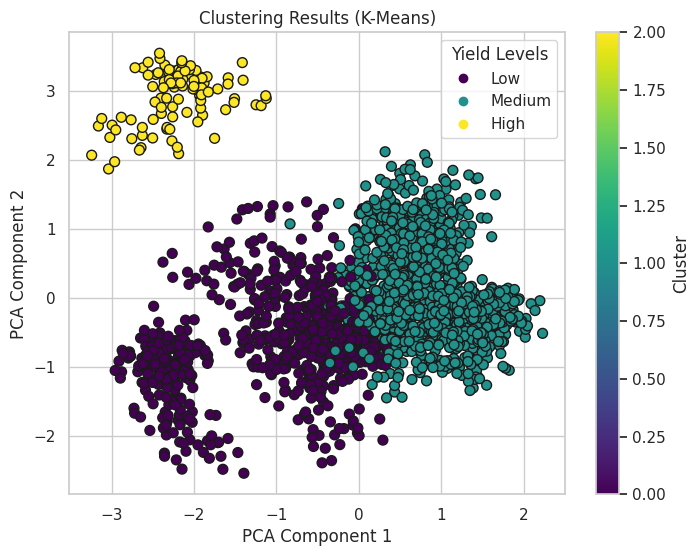

In [120]:
# Step 1: Remove outliers based on Z-Score threshold (e.g., |z| > 3 is considered an outlier)
z_scores = np.abs(stats.zscore(data))  # Get absolute z-scores
filtered_entries = (z_scores < 3).all(axis=1)  # Filter rows where all z-scores are within 3
data_filtered = data[filtered_entries].copy()  # Create a filtered DataFrame

# Step 2: Apply K-Means Clustering with k-means++ initialization to find 4 clusters
kmeans = KMeans(n_clusters=3, init='k-means++', n_init=10, max_iter=300, random_state=42)
kmeans.fit(data_filtered)

# Step 3: Map the cluster labels to 'Very Low Yield', 'Low Yield', 'Medium Yield', 'High Yield'
yield_labels = ['Low', 'Medium', 'High']
data_filtered['Yield'] = [yield_labels[label] for label in kmeans.labels_]  # Add 'Yield' column with labels

# Step 4: Visualize Clusters using PCA (reducing to 2D for visualization purposes)
pca = PCA(n_components=2)
X_pca = pca.fit_transform(data_filtered.drop(columns=['Yield']))  # Exclude 'Yield' for PCA

plt.figure(figsize=(8, 6))
scatter = plt.scatter(X_pca[:, 0], X_pca[:, 1], c=kmeans.labels_, cmap='viridis', marker='o', edgecolor='k', s=50)
plt.title('Clustering Results (K-Means)')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.colorbar(label='Cluster')
plt.legend(handles=scatter.legend_elements()[0], labels=yield_labels, title="Yield Levels")
plt.show()

Cluster the Independent Features

In [121]:
columns_to_cluster = ['Nitrogen', 'Phosphorus', 'Potassium', 'Temperature', 'Humidity', 'pH', 'Rainfall']

# Loop through each column to apply K-Means independently
for column in columns_to_cluster:
    # Initialize KMeans with 3 clusters
    kmeans = KMeans(n_clusters=3, random_state=42)

    # Reshape the column into a 2D array for fitting KMeans
    kmeans_labels = kmeans.fit_predict(cleaned_data[[column]])

    # Map the numeric labels to 'Low', 'Medium', and 'High'
    cluster_mapping = {0: 'Low', 1: 'Medium', 2: 'High'}
    cleaned_data[column + ' Level'] = pd.Series(kmeans_labels).map(cluster_mapping)


In [122]:
# Step 5: Merge the new 'Yield' column back into the original dataset if needed
cleaned_data['Yield'] = np.nan
cleaned_data.loc[filtered_entries, 'Yield'] = data_filtered['Yield']  # Only assign to non-outliers

<ipython-input-122-eb6a8898eb44>:3: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '['Medium' 'Medium' 'Medium' ... 'Medium' 'Medium' 'Medium']' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  cleaned_data.loc[filtered_entries, 'Yield'] = data_filtered['Yield']  # Only assign to non-outliers


In [123]:
cleaned_data.head()

,Nitrogen,Phosphorus,Potassium,Temperature,Humidity,pH,Rainfall,Crop,Nitrogen Level,Phosphorus Level,Potassium Level,Temperature Level,Humidity Level,pH Level,Rainfall Level,Yield
0,1.068797,-0.344551,-0.101688,-0.935587,0.472666,0.043302,1.810361,rice,Medium,Medium,High,High,Medium,Low,High,Medium
1,0.933329,0.140616,-0.141185,-0.759646,0.397051,0.734873,2.242058,rice,High,Low,High,High,Medium,Low,High,Medium
2,0.255986,0.049647,-0.081939,-0.515898,0.486954,1.771510,2.921066,rice,High,Low,High,Low,Medium,High,High,Medium
3,0.635298,-0.556811,-0.160933,0.172807,0.389805,0.660308,2.537048,rice,High,Medium,High,Low,Medium,Low,High,Medium
4,0.743673,-0.344551,-0.121436,-1.083647,0.454792,1.497868,2.898373,rice,High,Medium,High,High,Medium,High,High,Medium


In [68]:
unique, counts = np.unique(kmeans.labels_, return_counts=True)
cluster_sizes = dict(zip(unique, counts))
print("Cluster sizes:", cluster_sizes)


Cluster sizes: {0: 730, 1: 1197, 2: 102}


In [69]:
data_filtered['Cluster'] = kmeans.labels_

# Calculate the means of each feature for each admission status and cluster
cluster_means = data_filtered.groupby(['Cluster', 'Yield']).mean().reset_index()

# Display the means
print(cluster_means)

   Cluster   Yield  Nitrogen  Phosphorus  Potassium  Temperature  Humidity  \
0        0     Low -0.668280    0.163794  -0.373840     0.048575 -1.041300   
1        1  Medium  0.543198   -0.497837  -0.256558     0.010174  0.516129   
2        2    High -0.801731    2.436237   2.945023    -0.384773  0.728042   

         pH  Rainfall  
0  0.015821 -0.371405  
1  0.066710  0.211057  
2 -0.658150 -0.176714  


In [124]:
final_data = cleaned_data.dropna()

In [125]:
final_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2029 entries, 0 to 2199
Data columns (total 16 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Nitrogen           2029 non-null   float64
 1   Phosphorus         2029 non-null   float64
 2   Potassium          2029 non-null   float64
 3   Temperature        2029 non-null   float64
 4   Humidity           2029 non-null   float64
 5   pH                 2029 non-null   float64
 6   Rainfall           2029 non-null   float64
 7   Crop               2029 non-null   object 
 8   Nitrogen Level     2029 non-null   object 
 9   Phosphorus Level   2029 non-null   object 
 10  Potassium Level    2029 non-null   object 
 11  Temperature Level  2029 non-null   object 
 12  Humidity Level     2029 non-null   object 
 13  pH Level           2029 non-null   object 
 14  Rainfall Level     2029 non-null   object 
 15  Yield              2029 non-null   object 
dtypes: float64(7), object(9)
memo

In [126]:
from google.colab import files

final_data.to_csv('final_data.csv', index=False)
files.download('final_data.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# **Supervised Learning Using Clustered 'Admission' Results**

In [77]:
import pandas as pd
from sklearn.model_selection import train_test_split
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import classification_report

In [78]:
from google.colab import files
import io
import pandas as pd


uploaded = files.upload()
for file_name in uploaded.keys():
    data = pd.read_csv(io.BytesIO(uploaded[file_name]), delimiter=',')

Saving Final_Data.csv to Final_Data.csv


In [85]:
data = pd.read_csv('/content/Final_Data.csv', delimiter=',')

In [86]:
data.head()

,Nitrogen,Phosphorus,Potassium,Temperature,Humidity,pH,Rainfall,Crop,Yield
0,1.068797,-0.344551,-0.101688,-0.935587,0.472666,0.043302,1.810361,rice,Medium
1,0.933329,0.140616,-0.141185,-0.759646,0.397051,0.734873,2.242058,rice,Medium
2,0.255986,0.049647,-0.081939,-0.515898,0.486954,1.771510,2.921066,rice,Medium
3,0.635298,-0.556811,-0.160933,0.172807,0.389805,0.660308,2.537048,rice,Medium
4,0.743673,-0.344551,-0.121436,-1.083647,0.454792,1.497868,2.898373,rice,Medium


Data Augmentation for ML

In [88]:
from imblearn.over_sampling import SMOTE

# Assuming your dataset is called `data`
# 1. One-Hot Encode the 'Yield' Column
data['Yield'] = data['Yield'].astype('category')

# Apply Label Encoding to the 'Yield' column (to prepare for ML)
label_encoder = LabelEncoder()
data['Yield'] = label_encoder.fit_transform(data['Yield'])

# 2. Balance the dataset using SMOTE (for oversampling the minority class)
# Assuming 'data' has features and 'Yield' as the target variable.
X = data.drop(columns=['Yield', 'Crop'])  # Features
y = data['Yield']  # Target labels

# Perform SMOTE to balance the dataset
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X, y)

# Combine the resampled features and labels back into a DataFrame
augmented_data = pd.DataFrame(X_resampled, columns=X.columns)
augmented_data['Yield'] = y_resampled

# Display the resampled dataset
print(augmented_data['Yield'].value_counts())

# Preview the augmented dataset
print(augmented_data.head())


Yield
2    1197
1    1197
0    1197
Name: count, dtype: int64
   Nitrogen  Phosphorus  Potassium  Temperature  Humidity        pH  Rainfall  \
0  1.068797   -0.344551  -0.101688    -0.935587  0.472666  0.043302  1.810361   
1  0.933329    0.140616  -0.141185    -0.759646  0.397051  0.734873  2.242058   
2  0.255986    0.049647  -0.081939    -0.515898  0.486954  1.771510  2.921066   
3  0.635298   -0.556811  -0.160933     0.172807  0.389805  0.660308  2.537048   
4  0.743673   -0.344551  -0.121436    -1.083647  0.454792  1.497868  2.898373   

   Yield  
0      2  
1      2  
2      2  
3      2  
4      2  


In [89]:
data = augmented_data.copy()

In [91]:
data.head()

,Nitrogen,Phosphorus,Potassium,Temperature,Humidity,pH,Rainfall,Yield
0,1.068797,-0.344551,-0.101688,-0.935587,0.472666,0.043302,1.810361,2
1,0.933329,0.140616,-0.141185,-0.759646,0.397051,0.734873,2.242058,2
2,0.255986,0.049647,-0.081939,-0.515898,0.486954,1.771510,2.921066,2
3,0.635298,-0.556811,-0.160933,0.172807,0.389805,0.660308,2.537048,2
4,0.743673,-0.344551,-0.121436,-1.083647,0.454792,1.497868,2.898373,2


In [93]:
# Define features (X) and target (y)

X = data.drop(columns=['Yield'])  # Features (everything except the target column)+
y = data['Yield']  # Target column

# Split the data into training, validation, and test sets (80% train, 10% validation, 10% test)
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.2, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# Build the deep learning model
model = keras.Sequential([
    layers.Dense(64, activation='relu', input_shape=(X_train.shape[1],)),  # Input layer
    layers.Dropout(0.5),  # Dropout to avoid overfitting
    layers.Dense(32, activation='relu'),  # Hidden layer
    layers.Dropout(0.5),  # Another Dropout layer
    layers.Dense(1, activation='sigmoid')  # Output layer with sigmoid for binary classification
])

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Early stopping to prevent overfitting
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Train the model
history = model.fit(X_train, y_train,
                    validation_data=(X_val, y_val),
                    epochs=10,
                    batch_size=32,
                    callbacks=[early_stopping])

# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {test_accuracy:.4f}")

# After evaluating the model on the test set, generate predictions
y_pred = (model.predict(X_test) > 0.5).astype("int32")  # Convert probabilities to binary predictions

# Generate a classification report (including precision, recall, and F1-score)
report = classification_report(y_test, y_pred, target_names=['Low', 'Medium', 'High'])
print(report)

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/10
90/90 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.5343 - loss: -0.0214 - val_accuracy: 0.7159 - val_loss: -1.6432
Epoch 2/10
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6417 - loss: -4.0280 - val_accuracy: 0.7159 - val_loss: -10.8584
Epoch 3/10
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6333 - loss: -23.3970 - val_accuracy: 0.7159 - val_loss: -44.7625
Epoch 4/10
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6438 - loss: -83.0629 - val_accuracy: 0.7159 - val_loss: -127.0148
Epoch 5/10
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6458 - loss: -215.1355 - val_accuracy: 0.7159 - val_loss: -275.4505
Epoch 6/10
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6497 - loss: -440.6986 - val_accuracy: 0.7159 - val_loss: -508.5206
Epoch 7/10
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6636 - loss: -762.2725 - val_accuracy: 0.7159 - val_loss: -832.3500
Epoch 8/10
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6431 - loss: -1293.886

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


The was no effect of data augmentation on the prediction of high yield.